In [2]:
import openvino as ov
import cv2
from PIL import Image
import numpy as np
import torch
from util import read_model_ov, show_detect_openvino, show_detect_torch, detect, draw_results, YOLO, VideoPlayer
import ipywidgets as widgets

In [3]:
import ipywidgets as widgets
import openvino as ov

#tạo openvino runtime
core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [4]:
path_model_ov_vehicle = r"C:\Users\TranNgocDu\Documents\LPRecognition\LP_recognition\modelCar_detection_openvino_int8_model\Car_detection.xml"
path_model_ov_lp = r"C:\Users\TranNgocDu\Documents\LPRecognition\LP_recognition\model\best_lp_detection_yolov8n_openvino_model\best_lp_detection_yolov8n.xml"
path_model_torch_lp = r"C:\Users\TranNgocDu\Documents\LPRecognition\LP_recognition\model\best_lp_detection_yolov8n.pt"
img_path_sample_vh = r"C:\Users\TranNgocDu\Documents\LPRecognition\datasets\Vehicle_detection\valid\images\frame6600_jpg.rf.b3f690620e9699246151d0e0f94948d3.jpg"


In [6]:
ov_vehicle, ov_vehicle_compiled = read_model_ov(path_model_ov_vehicle, device)
ov_lp, ov_lp_compiled = read_model_ov(path_model_ov_lp, device)
torch_lp = YOLO(path_model_torch_lp)

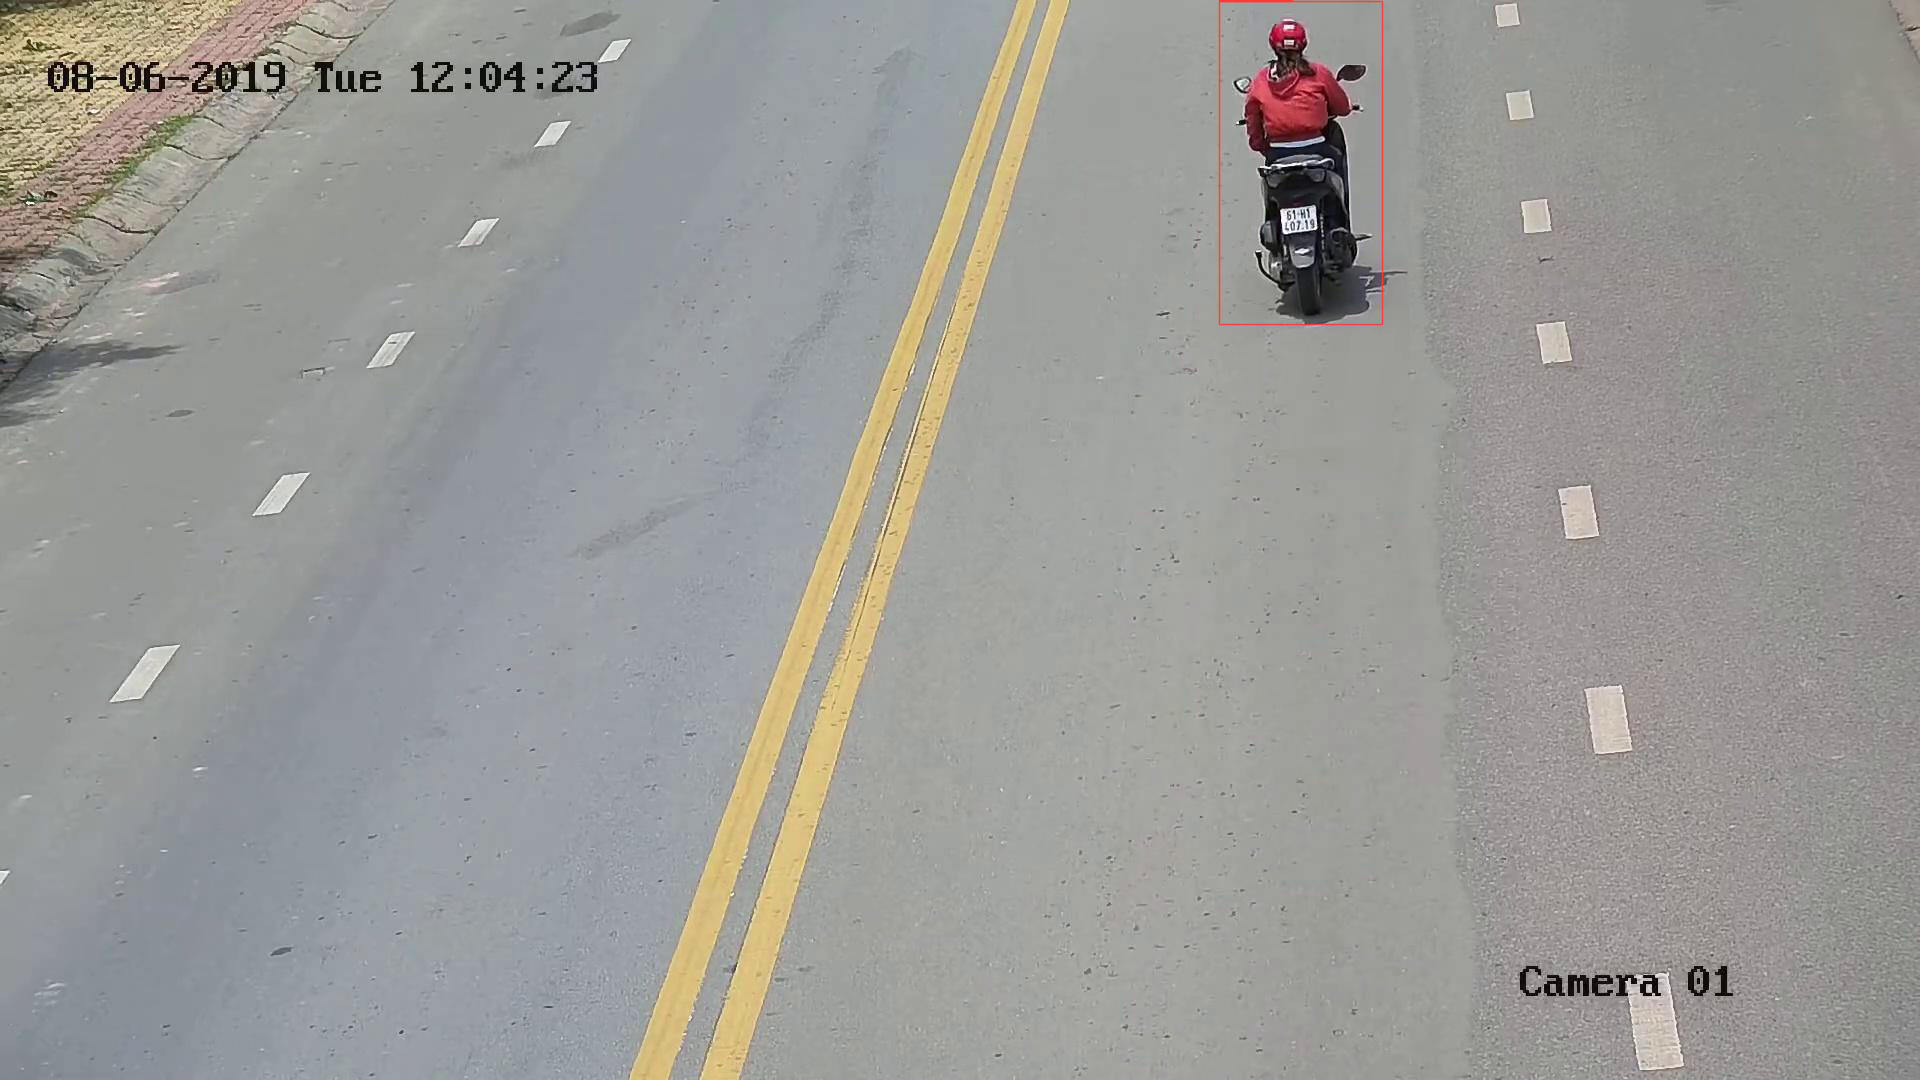

In [7]:
show_detect_openvino(ov_vehicle_compiled,\
                      img_path_sample_vh,\
                        {0:"xe4banh", 1:"xe2banh"})

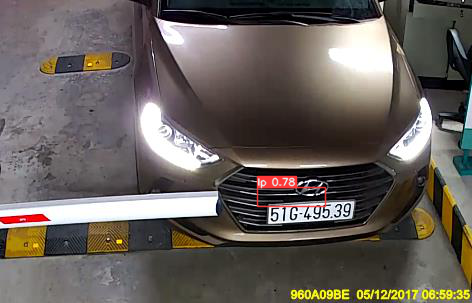

In [8]:
show_detect_openvino(ov_lp_compiled,\
                      r"C:\Users\TranNgocDu\Documents\LPRecognition\datasets\LP_detection\images\val\CarLongPlate105.jpg",\
                        {0:"lp"}, nc=1)


image 1/1 C:\Users\TranNgocDu\Documents\LPRecognition\datasets\LP_detection\images\val\CarLongPlate105.jpg: 416x640 1 lp, 224.9ms
Speed: 0.0ms preprocess, 224.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


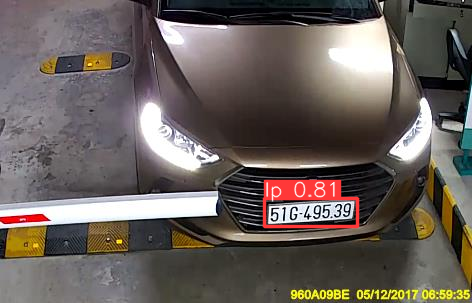

In [69]:
show_detect_torch(torch_lp, r"C:\Users\TranNgocDu\Documents\LPRecognition\datasets\LP_detection\images\val\CarLongPlate105.jpg")

In [9]:
full_img = np.array(Image.open(img_path_sample_vh))
detections = detect(full_img, ov_vehicle_compiled)[0]["det"]
all_detection = []
for idx, (x_min, y_min, x_max, y_max, conf, lbl) in enumerate(detections):
    print(x_min, y_min, x_max, y_max)
    patches_crop = full_img[int(y_min):int(y_max), int(x_min):int(x_max)]
    lp_detections = torch_lp(patches_crop, verbose=False)[0].boxes
    lp_detections = torch.cat([lp_detections.xyxy + torch.stack((x_min, y_min, x_min, y_min)), lp_detections.conf.unsqueeze(0), lp_detections.cls.unsqueeze(0)+2], dim=1)
    print(lp_detections)
    print(detections[idx:idx+1].shape, lp_detections.shape)
    all_detection.extend([detections[idx:idx+1], lp_detections])
all_detection = torch.cat(all_detection, dim=0)
     

tensor(1219.) tensor(1.) tensor(1382.) tensor(324.)
tensor([[1.2789e+03, 2.0400e+02, 1.3197e+03, 2.3471e+02, 8.3976e-01, 2.0000e+00]])
torch.Size([1, 6]) torch.Size([1, 6])


In [25]:
lp_detections = torch_lp(patches_crop, verbose=False)[0].boxes
print(lp_detections.conf[:1].shape)

torch.Size([1])


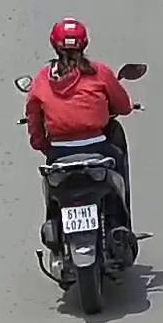

In [12]:
Image.fromarray(patches_crop)

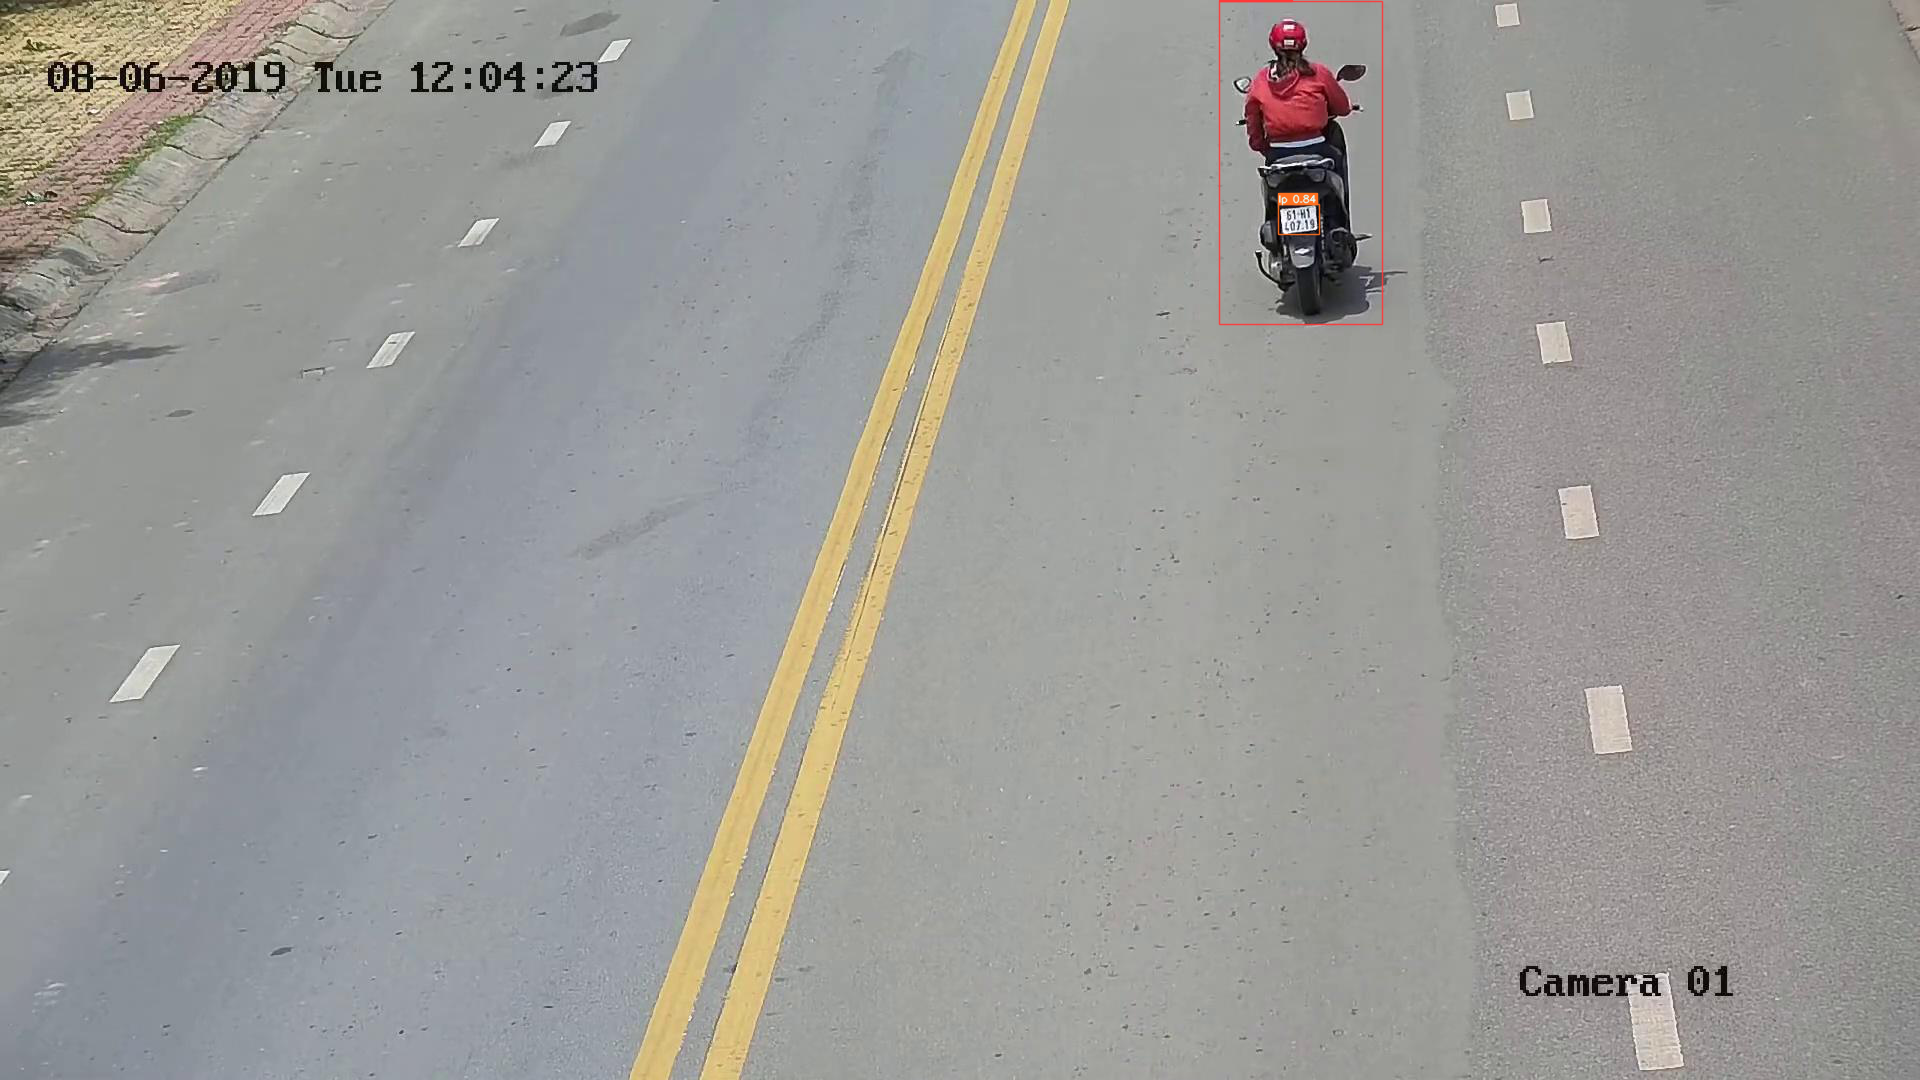

In [14]:
image_with_boxes = draw_results({"det":all_detection}, full_img, {0:"xe4banh", 1:"xe2banh", 2:"lp"})
Image.fromarray(image_with_boxes)

In [26]:
import collections
import time
from IPython import display


# Main processing function to run object detection.
def run_object_detection(source=0, flip=False, use_popup=False, skip_first_frames=0, model=ov_vehicle, device=device.value):
    player = None
    if device != "CPU":
        model.reshape({0: [1, 3, 640, 640]})
    compiled_model = core.compile_model(model, device)
 
    # Create a video player to play with target fps.
    player = VideoPlayer(
        source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
    )
    # Start capturing.
    player.start()
    if use_popup:
        title = "Press ESC to Exit"
        cv2.namedWindow(
            winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
        )

    processing_times = collections.deque()
    flag = True
    while flag:
        # Grab the frame.
        frame = player.next()
        if frame is None:
            print("Source ended")
            break
        # If the frame is larger than full HD, reduce size to improve the performance.
        scale = 1280 / max(frame.shape)
        if scale < 1:
            frame = cv2.resize(
                src=frame,
                dsize=None,
                fx=scale,
                fy=scale,
                interpolation=cv2.INTER_AREA,
            )
        # Get the results.
        input_image = np.array(frame)
        
        start_time = time.time()
        # model expects RGB image, while video capturing in BGR
        # detections = detect(input_image[:, :, ::-1], compiled_model)[0]
        input_image_convert_ch = input_image[:, :, ::-1]
        detections = detect(input_image_convert_ch, compiled_model)[0]["det"]
        all_detections = []
        for idx, (x_min, y_min, x_max, y_max, conf, lbl) in enumerate(detections): #car detection
            patches_crop = input_image_convert_ch[int(y_min):int(y_max), int(x_min):int(x_max)]
            lp_detections = torch_lp(patches_crop, verbose=False)[0].boxes
            
            # print("len detection:",len(lp_detections))
            if len(lp_detections)==0:
                all_detections.extend([detections[idx:idx+1]])
            else:
                lp_detections = torch.cat([lp_detections.xyxy[:1] + torch.stack((x_min, y_min, x_min, y_min)), lp_detections.conf[:1].unsqueeze(0), lp_detections.cls[:1].unsqueeze(0)+2], dim=1)
                all_detections.extend([detections[idx:idx+1], lp_detections])
            
        

        stop_time = time.time()

        if len(all_detections)==0:
            pass
        else:
            all_detections = torch.cat(all_detections, dim=0)
            # print(all_detections.shape)
            image_with_boxes = draw_results({"det":all_detections}, input_image,  {0:"xe4banh", 1:"xe2banh", 2:"lp"})
            frame = image_with_boxes
        
        processing_times.append(stop_time - start_time)
        # Use processing times from last 200 frames.
        if len(processing_times) > 200:
            processing_times.popleft()

        _, f_width = frame.shape[:2]
        # Mean processing time [ms].
        processing_time = np.mean(processing_times) * 1000
        fps = 1000 / processing_time
        cv2.putText(
            img=frame,
            text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
            org=(20, 40),
            fontFace=cv2.FONT_HERSHEY_COMPLEX,
            fontScale=f_width / 1000,
            color=(0, 0, 255),
            thickness=1,
            lineType=cv2.LINE_AA,
        )
        
        # Use this workaround if there is flickering.
        if use_popup:
            cv2.imshow(winname=title, mat=frame)
            key = cv2.waitKey(1)
            # escape = 27
            if key == 27:
                break
        else:
            # Encode numpy array to jpg.
            _, encoded_img = cv2.imencode(
                ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
            )
            # Create an IPython image.
            i = display.Image(data=encoded_img)
            # Display the image in this notebook.
            display.clear_output(wait=True)
            display.display(i)
    # # ctrl-c
    # except KeyboardInterrupt:
    #     print("Interrupted")
    # # any different error
    # except RuntimeError as e:
    #     print(e)
    # finally:
    if player is not None:
        # Stop capturing.
        player.stop()
    if use_popup:
        cv2.destroyAllWindows()

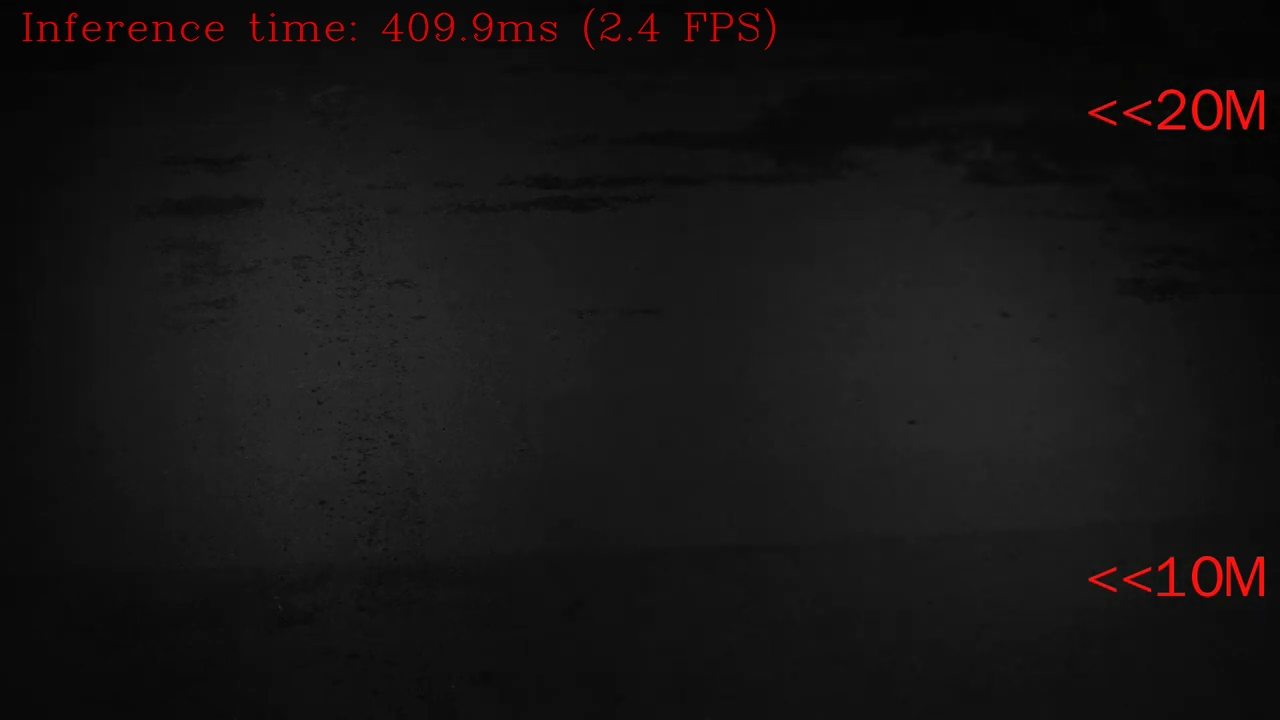

Source ended


In [27]:
VIDEO_SOURCE = r"C:\Users\TranNgocDu\Documents\LPRecognition\video1.mp4"
run_object_detection(source=VIDEO_SOURCE, flip=False, use_popup=False, model=ov_vehicle, device=device.value)